# 

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from problems import Knapsack

from circuit_lengths import add_lengths_to_df
from regressor import fit_multi

import matplotlib.colors as mco

import quantum_plots as qp
_ = qp.global_setup()

In [5]:
df = pd.read_feather("../../results/qpe_main.feather")

In [4]:
df = df[df.qaoa != "kickback_cost"]

In [5]:
df["method"] = df.qaoa + df["ancilla"].transform(lambda x: "" if np.isnan(x) else "_" + str(int(x)))

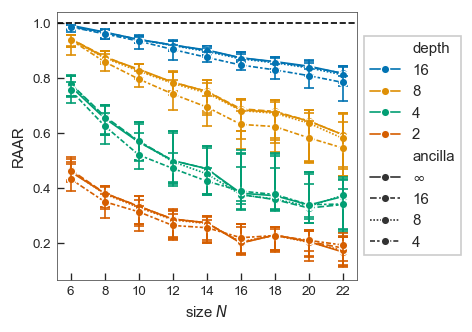

In [334]:
fig, _ = qp.plot_setup(aspect_ratio=0.9)

methods = ["qpe_4", "qpe_8", "qpe_16", "masked_cost"]

dfx = df.query("method in @methods and depth >= 2").copy()
dfx["ancilla"] = dfx.ancilla.transform(lambda x: r"$\infty$" if np.isnan(x) else str(int(x)))
    
l = sns.lineplot(
    dfx, 
    x="n_qubits",
    y="rnd_approx_ratio",
    hue="depth",
    style="ancilla",
    hue_order=[16, 8, 4, 2],
    style_order=[r"$\infty$", "16", "8", "4"],
    legend=True,
    estimator=np.median,
    err_style="bars",
    err_kws={"capsize": 3},
    errorbar=("pi", 50),
    marker="o",
    markersize=5,
    palette="colorblind",
)

plt.axhline(y=1, c="k", ls="--")

sns.move_legend(l, loc="center left", bbox_to_anchor=(1, 0.5))

plt.xlabel("size $N$")
plt.ylabel("RAAR")

plt.xticks(range(6, 24, 2), range(6, 24, 2));

#.sns.stripplot(df.query("depth == 8"), x="n_qubits", y="rnd_approx_ratio", hue="method", dodge=True, alpha=0.1, legend=False, marker='.', palette="dark", jitter=False)

# plt.yscale("log")

plt.savefig("plots/qpe_raar.pdf", bbox_inches="tight", transparent=True)

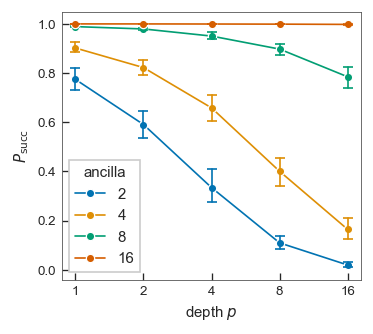

In [99]:
fig, _ = qp.plot_setup(aspect_ratio=0.9)

df["1mp"] = 1 - df.p_succ

dfx = df.query("qaoa == 'qpe'").copy()
dfx.ancilla = dfx.ancilla.astype(int)

sns.lineplot(
    dfx, 
    x="depth",
    y="p_succ",
    hue="ancilla",
    # style="n_qubits",
    legend=True,
    estimator=np.median,
    errorbar=("pi", 50),
    err_style="bars",
    err_kws={"capsize": 3},
    marker="o",
    markersize=5,
    palette="colorblind"
)
#plt.yscale("log")
plt.xscale("log")

plt.ylabel(r"$P_{\mathrm{succ}}$")
plt.xlabel("depth $p$")

plt.xticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])

plt.savefig("plots/qpe_psucc.pdf", bbox_inches="tight", transparent=True)

In [59]:
df.query("depth == 1").p_succ.describe()

count    2304.000000
mean        0.916352
std         0.096604
min         0.602619
25%         0.864179
50%         0.972344
75%         0.995217
max         0.999987
Name: p_succ, dtype: float64

In [121]:
add_lengths_to_df(df, Knapsack)

In [123]:
df.clops.max()

2128.0

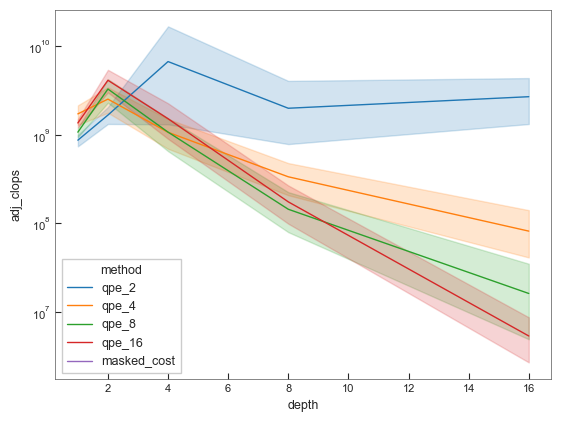

In [109]:
df["adj_clops"] = df.clops * np.ceil(np.log(0.01) / np.log(1 - df.p_opt * df.p_succ))
sns.lineplot(df.query("n_qubits == 22"), x="depth", y="adj_clops", hue="method")
plt.yscale("log")

In [101]:
df["log_adj_clops"] = np.log(df.adj_clops)

df_fit = fit_multi(df.query("qaoa == 'qpe'"), x="n_qubits", y="log_adj_clops", groupby=["method", "depth"])

df_fit

slope  intercept    rvalue     lower     upper
method depth                                                   
qpe_16 1      0.712027   5.132122  0.964882  0.700891  0.723163
       2      0.743706   4.657261  0.880411  0.721235  0.766176
       4      0.671042   4.389322  0.807755  0.644204  0.697879
       8      0.517660   5.105816  0.822984  0.497978  0.537342
       16     0.342953   6.502480  0.808929  0.329289  0.356618
qpe_2  1      0.738593   4.245878  0.949125  0.724575  0.752612
       2      0.726981   4.464407  0.911429  0.708402  0.745559
       4      0.698382   4.649870  0.862078  0.675481  0.721282
       8      0.562113   6.662911  0.811727  0.539919  0.584306
       16     0.472260   9.439418  0.630130  0.442598  0.501921
qpe_4  1      0.760071   4.084806  0.948035  0.745482  0.774659
       2      0.755610   4.093132  0.882960  0.733057  0.778163
       4      0.706498   3.840556  0.866358  0.683750  0.729246
       8      0.570317   5.084356  0.838420  0.549792  0.590843
       16     0.418164   7.312109  0.720541  0.396815  0.439514
qpe_8  1      0.739901   4.384328  0.967347  0.728757  0.751046
       2      0.764007   3.994523  0.878697  0.740736  0.787279
       4      0.694635   3.731546  0.822694  0.668198  0.721072
       8      0.543297   4.540112  0.838478  0.523749  0.562846
       16     0.371528   6.127603  0.794070  0.356017  0.387038

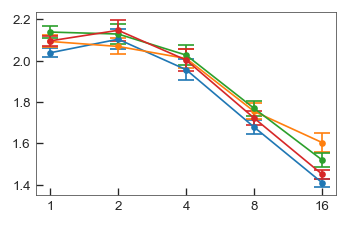

In [103]:
qp.plot_setup()
df_fit["exp_slope"] = np.exp(df_fit.slope)

dfx = df_fit.reset_index()
def plot_method(x):
    bounds = np.abs(np.exp(x[["lower", "upper"]].to_numpy().T) - np.exp(x.slope.to_numpy()[None, :]))
    plt.errorbar(np.arange(len(x.depth)), np.exp(x.slope), yerr=bounds, capsize=5, marker="o")

dfx.groupby("method").apply(plot_method)
_ = plt.xticks(np.arange(len(dfx.depth.drop_duplicates())), dfx.depth.drop_duplicates().astype(int))
# sns.pointplot(df_fit, x="depth", y="slope", hue="method")

In [539]:
df2 = pd.read_feather("../../results/qpe_scaling.feather")
df2["method"] = df2.qaoa + df2["ancilla"].transform(lambda x: "" if np.isnan(x) else "_" + str(int(x)))

df2["ancilla2"] = df2.ancilla.transform(lambda x: r"$\infty$" if np.isnan(x) else str(int(x)))

In [540]:
add_lengths_to_df(df2, Knapsack)

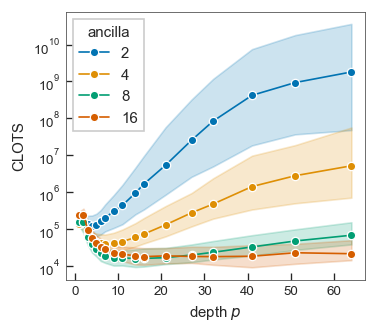

In [541]:
qp.plot_setup(aspect_ratio=0.9)

df2["p_tot"] = df2.p_succ.fillna(1) * df2.p_opt
df2["reps"] =  np.ceil(np.log(0.01) / np.log(1 - df2.p_tot))
df2["adj_clops"] = df2.reps * df2.clops
df2["1mp"] = 1 - df2.p_opt

df2["ancilla"] = df2["ancilla"].transform(lambda x: 0 if np.isnan(x) else int(x))
sns.lineplot(df2.query("n_qubits == 10 and ancilla > 0"), x="depth", y="adj_clops", hue="ancilla", palette="colorblind", estimator=np.median, marker="o", markersize=5, errorbar=("pi", 50))
plt.yscale("log")

plt.xlabel("depth $p$")
plt.ylabel("CLOTS")

plt.savefig("plots/qpe_clots.pdf", bbox_inches="tight", transparent=True)

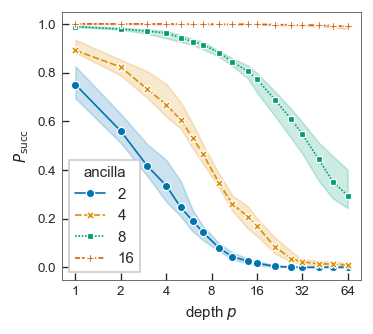

In [542]:
fig, _ = qp.plot_setup(aspect_ratio=0.9)

hue_order = ["2", "4", "8", "16"]# r"$\infty$"]

n_qubits = 16

res = sns.lineplot(
    df2.query("ancilla > 0 and n_qubits == @n_qubits"), 
    x="depth",
    y="p_succ",
    hue="ancilla2",
    # style="n_qubits",
    legend=True,
    estimator=np.median,
    errorbar=("pi", 50),
    # err_style="bars",
    # err_kws={"capsize": 3},
    markers=True,
    style="ancilla2",
    markersize=5,
    palette="colorblind",
    hue_order=hue_order,
    style_order=hue_order
)

plt.xscale("log")

plt.xticks([1 << i for i in range(7)], [1 << i for i in range(7)])
plt.xlabel("depth $p$")
plt.ylabel("$P_\mathrm{succ}$")
sns.move_legend(res, loc="lower left", title="ancilla")

plt.savefig("plots/qpe_psucc_16.pdf", bbox_inches="tight", transparent=True)

In [532]:
df2.n_qubits

0         6
1         6
2         6
3         6
4         6
         ..
70715    12
70716    12
70717    12
70718    12
70719    12
Name: n_qubits, Length: 70720, dtype: int64

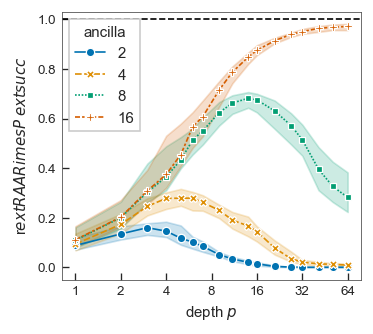

In [550]:
fig, _ = qp.plot_setup(aspect_ratio=0.9)

df2["rnd_approx_ratio_psucc"] = df2.rnd_approx_ratio * df2.p_succ


res = sns.lineplot(
    df2.query("ancilla > 0 and n_qubits == @n_qubits"), 
    x="depth",
    y="rnd_approx_ratio_psucc",
    hue="ancilla2",
    # style="n_qubits",
    legend=True,
    estimator=np.median,
    errorbar=("pi", 50),
    # err_style="bars",
    # err_kws={"capsize": 3},
    markers=True,
    markersize=5,
    palette="colorblind",
    style="ancilla2",
    alpha=1,
    hue_order=hue_order,
    style_order=hue_order
)

plt.xscale("log")

plt.xticks([1 << i for i in range(7)], [1 << i for i in range(7)])
plt.xlabel("depth $p$")
plt.ylabel("r$\text{RAAR} \times P_\text{succ}$")
sns.move_legend(res, loc="upper left", title="ancilla")

plt.axhline(y=1, c="k", ls="--")



plt.savefig("plots/qpe_raar_psucc_16.pdf", bbox_inches="tight", transparent=True)

In [161]:
df2["log_adj_clops"] = np.log10(df2["adj_clops"])

df_fit = fit_multi(df2.query("qaoa == 'qpe'"), x="n_qubits", y="log_adj_clops", groupby=["method", "depth"])

([<matplotlib.axis.XTick at 0x28ce87ee0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(8, 0, '8'),
  Text(16, 0, '16'),
  Text(32, 0, '32'),
  Text(64, 0, '64')])

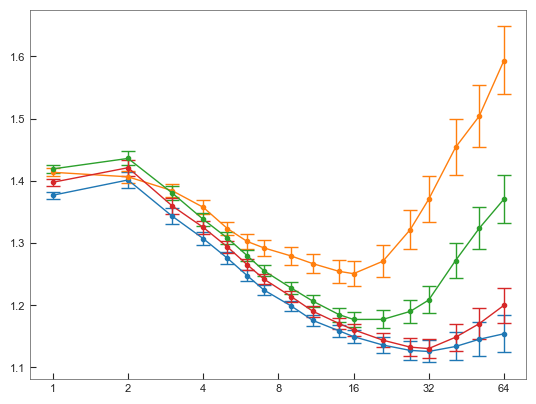

In [173]:
dfx = df_fit.reset_index()
def plot_method(x):
    bounds = np.abs(np.exp(x[["lower", "upper"]].to_numpy().T) - np.exp(x.slope.to_numpy()[None, :]))
    plt.errorbar(x.depth, np.exp(x.slope), yerr=bounds, capsize=5, marker="o")

dfx.groupby("method").apply(plot_method)
plt.xscale("log")
plt.xticks([1 << i for i in range(7)], [1 << i for i in range(7)])
# sns.pointplot(df_fit, x="depth", y="slope", hue="method")

# Transfer masked QAOA paramters

In [11]:
from fastqaoa.ctypes.qpe_qaoa import qpe_qaoa
from fastqaoa.ctypes.qaoa import qaoa

from fastqaoa.indicator import get_indicator_interpolator, interpolate_diagonals
from fastqaoa.ctypes.metrics import Metrics

In [12]:
interp = get_indicator_interpolator(8, 4, 0.6)

ks = Knapsack.get_instances()[6][0]

In [65]:
dfd = df2.query("qaoa == 'masked_cost' and n_qubits == 6")

interps = {
    2: get_indicator_interpolator(2, 4, shift=0.6),
    4: get_indicator_interpolator(4, 4, shift=0.6),
    8: get_indicator_interpolator(8, 4, shift=0.6),
    16: get_indicator_interpolator(16, 4, shift=0.6),
}

In [67]:
def func(x):
    res = []
    prb = Knapsack.get_instances()[x.n_qubits][x.problem_id]
    cost, weights = prb.diagonalized()
    masked_cost = prb.masked_cost()

    cost = cost / np.abs(masked_cost.min_val) * cost.n_qubits

    constr_org = weights.scale_between_sym()

    data = dict(x).copy()
    data["qaoa"] = "masked_cost"
    data["initial"] = "from_exact"
    mc = masked_cost / np.abs(masked_cost.min_val) * masked_cost.n_qubits
    sv = qaoa(mc, x.betas, x.gammas)
    
    new_data = Metrics.compute(sv, masked_cost, weights).dump()
    res.append(data)
    
    
    for i, interp in interps.items():
        constr = interpolate_diagonals(interp, constr_org)
        sv, psucc = qpe_qaoa(cost, constr, x.betas, x.gammas)
    
        new_data = Metrics.compute(sv, masked_cost, weights).dump()
    
        data = dict(x).copy()
        data["qaoa"] = "qpe"
        data["ancilla"] = i
        data["initial"] = "from_exact"
        data["p_succ"] = psucc
        data["shift"] = 0.6
        data.update(new_data)
    
        res.append(data)

    prb.decache()

    return pd.DataFrame(res)

x = dfd.apply(func, axis=1)
df3 = pd.concat(list(x))
add_lengths_to_df(df3, Knapsack)

df3

,depth,energy,approx_ratio,feas_ratio,feas_approx_ratio,p_opt,p_999,p_99,p_9,rnd_approx_ratio,...,beta_scale,gamma_scale,p_succ,ancilla,shift,method,clops,two_qubit_ops,weight_ratio,feas_perc
0,1,-19.813839,0.232784,0.357570,0.651016,0.059694,0.059694,0.059694,0.119797,0.166117,...,0.1,0.1,NaN,NaN,NaN,masked_cost,NaN,NaN,0.385883,0.312500
1,1,-0.635988,0.261120,0.477133,0.547269,0.042587,0.042587,0.042587,0.042587,0.131688,...,0.1,0.1,0.749943,2.0,0.6,masked_cost,29.0,32.0,0.385883,0.312500
2,1,-0.740632,0.305302,0.550787,0.554302,0.068003,0.068003,0.068003,0.068003,0.180893,...,0.1,0.1,0.903255,4.0,0.6,masked_cost,37.0,66.0,0.385883,0.312500
3,1,-0.761304,0.314252,0.567378,0.553868,0.070694,0.070694,0.070694,0.070694,0.190613,...,0.1,0.1,0.984958,8.0,0.6,masked_cost,57.0,158.0,0.385883,0.312500
4,1,-0.762030,0.314651,0.568671,0.553309,0.070762,0.070762,0.070762,0.070762,0.190954,...,0.1,0.1,0.992570,16.0,0.6,masked_cost,105.0,438.0,0.385883,0.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,64,-60.999413,0.999991,0.999999,0.999993,0.999972,0.999972,0.999972,0.999973,0.999988,...,0.1,0.1,NaN,NaN,NaN,masked_cost,NaN,NaN,0.480410,0.484375
1,64,-2.356541,0.993859,0.999908,0.993951,0.955362,0.955362,0.955362,0.955362,0.992015,...,0.1,0.1,0.049142,2.0,0.6,masked_cost,1856.0,2048.0,0.480410,0.484375
2,64,-2.124094,0.895826,0.999703,0.896092,0.156732,0.156732,0.156732,0.156732,0.864546,...,0.1,0.1,0.027225,4.0,0.6,masked_cost,2368.0,4224.0,0.480410,0.484375
3,64,-2.369279,0.999231,0.999988,0.999243,0.997159,0.997159,0.997159,0.997159,0.999000,...,0.1,0.1,0.501072,8.0,0.6,masked_cost,3648.0,10112.0,0.480410,0.484375


### Why is paramter transfer so bad?
Not shift set but other param

In [63]:
prb = Knapsack.get_instances()[6][0]
cost, weights = prb.diagonalized()
masked_cost = prb.masked_cost()

scale = cost.n_qubits / np.abs(masked_cost.min_val)

cost = cost * scale

constr_org = weights.scale_between_sym()

mc = masked_cost * scale

x = dfd.query("n_qubits == 6 and problem_id == 0 and depth == 1").iloc[0]

sv1 = qaoa(mc, x.betas, x.gammas)

interp = get_indicator_interpolator(16, 4, shift=0.6)

constr = interpolate_diagonals(interp, constr_org)
sv2, psucc = qpe_qaoa(cost, constr, x.betas, x.gammas)
print(psucc)
    
print(Metrics.compute(sv1, masked_cost, weights).dump())
print(Metrics.compute(sv2, masked_cost, weights).dump())

0.9925698521721662
{'energy': -0.7744381840478336, 'approx_ratio': 0.3119445073865464, 'feas_ratio': 0.5641492729193094, 'feas_approx_ratio': 0.5529467507284441, 'p_opt': 0.06992970666501333, 'p_999': 0.06992970666501333, 'p_99': 0.06992970666501333, 'p_9': 0.06992970666501333, 'rnd_approx_ratio': 0.1967888957558819, 'min_val': -2.482615227099312, 'rnd_val': -0.3559301825007303, 'max_val': 0.0}
{'energy': -0.781156732559695, 'approx_ratio': 0.3146507457268757, 'feas_ratio': 0.568670838172782, 'feas_approx_ratio': 0.5533090930737578, 'p_opt': 0.07076152335550491, 'p_999': 0.07076152335550491, 'p_99': 0.07076152335550491, 'p_9': 0.07076152335550491, 'rnd_approx_ratio': 0.1999480605456684, 'min_val': -2.482615227099312, 'rnd_val': -0.3559301825007303, 'max_val': 0.0}


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  2.,  0.,  1.,
         1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0., 45.]),
 array([-6.  , -5.88, -5.76, -5.64, -5.52, -5.4 , -5.28, -5.16, -5.04,
        -4.92, -4.8 , -4.68, -4.56, -4.44, -4.32, -4.2 , -4.08, -3.96,
        -3.84, -3.72, -3.6 , -3.48, -3.36, -3.24, -3.12, -3.  , -2.88,
        -2.76, -2.64, -2.52, -2.4 , -2.28, -2.16, -2.04, -1.92, -1.8 ,
        -1.68, -1.56, -1.44, -1.32, -1.2 , -1.08, -0.96, -0.84, -0.72,
        -0.6 , -0.48, -0.36, -0.24, -0.12,  0.  ]),
 <BarContainer object of 50 artists>)

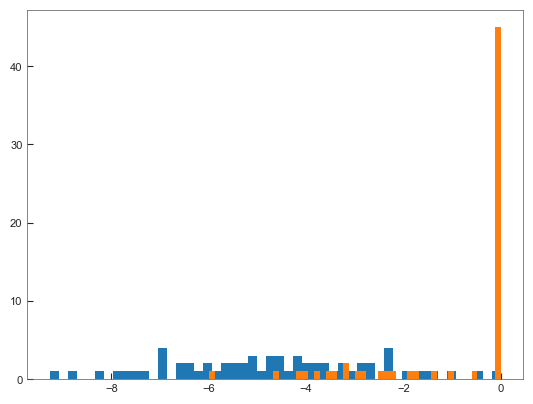

In [64]:
plt.hist(cost.to_numpy(), bins=50)
plt.hist(mc.to_numpy(), bins=50)

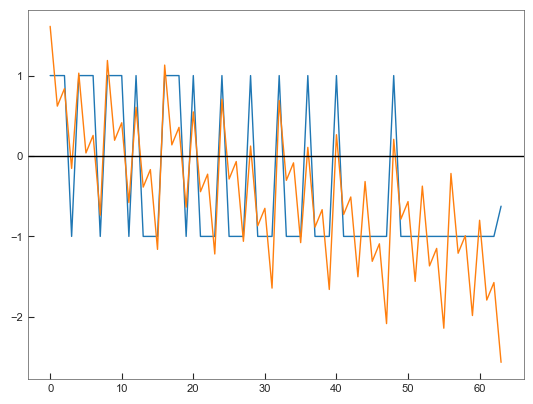

In [62]:
plt.plot(constr.to_numpy())
plt.plot(weights.to_numpy())
plt.axhline(0, color="k")

In [470]:
interps = {}

from fastqaoa.ctypes.optimize import optimize_qaoa_lbfgs

def get_interp_with_shift(M, shift):
    global shifts
    if not (M, shift) in interps:
        interps[M, shift] = get_indicator_interpolator(M, 4, shift=shift)
    return interps[M, shift]

depths = [1, 2, 4, 9, 16, 32, 64]
dfx = df2.query("qaoa == 'masked_cost' and depth in @depths")

shifts = np.linspace(0.0, 2, 11).round(3)

M = 16


def compute_for_instance(prb):
    size = prb.n_qubits
    instance = prb.id
    print(instance)

    dfi = dfx.query("n_qubits == @size and problem_id == @instance")

    cost, weights = prb.diagonalized()
    masked_cost = prb.masked_cost()

    scale = cost.n_qubits / np.abs(masked_cost.min_val)

    cost = cost * scale

    # constr_org = weights.scale_between_sym()

    mscale = max(np.abs(weights.min_val), np.abs(weights.max_val) / (1 - 2 ** -M))
    constr_org = weights / mscale
    # constr_org = constr_org * 0.5

    mc = masked_cost * scale

    data = []

    for _, x in dfi.iterrows():
        for s in shifts:        
            interp = get_interp_with_shift(M, s)
            
            constr = interpolate_diagonals(interp, constr_org)
            # constr = 2 * (constr_org >= 0)
            # constr += -1.
            res = optimize_qaoa_lbfgs(cost, mc, x.betas, x.gammas, constr=constr)
            sv2, psucc = qpe_qaoa(cost, constr, res.betas, res.gammas)
                
            data.append({"size": size, "instance": instance, "shift": s, "M": M, "depth": x.depth, "psucc": psucc, **Metrics.compute(sv2, masked_cost, weights).dump(), "orig": x.approx_ratio})
    dfz = pd.DataFrame(data)
    dfz["perc"] = dfz.approx_ratio / dfz.orig
    return dfz

In [471]:
from problems import IntegerKnapsack

prbs = Knapsack.get_instances()[8][:64]
res = pd.concat(map(compute_for_instance, prbs))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [474]:
res["rel_approx_ratio"] = res.groupby(["size", "instance", "depth"], group_keys=False).approx_ratio.apply(lambda x: x / x.max())

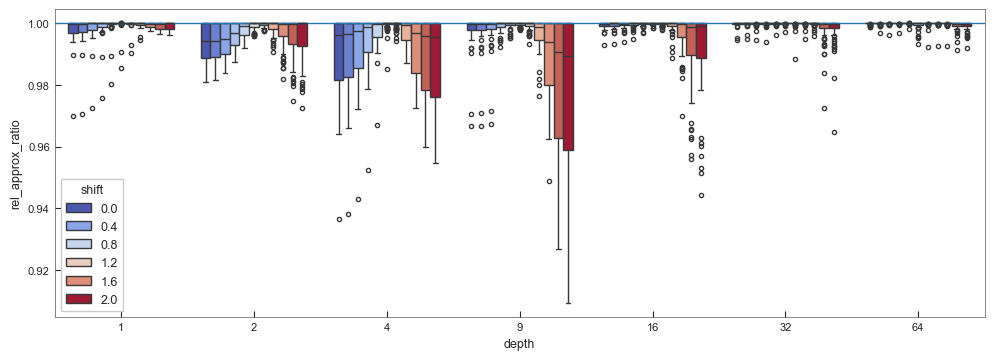

In [479]:
plt.subplots(figsize=(12, 4))

sns.boxplot(res, x="depth", y="rel_approx_ratio", hue="shift", palette="coolwarm")
plt.axhline(y=1)

In [428]:
res.query("instance == 6 and depth == 64")

,size,instance,shift,M,depth,psucc,energy,approx_ratio,feas_ratio,feas_approx_ratio,...,p_999,p_99,p_9,rnd_approx_ratio,min_val,rnd_val,max_val,orig,perc,rel_approx_ratio
66,8,6,0.30,6,64,0.162019,-2.783503,0.995978,0.999873,0.996105,...,0.531414,0.994881,0.995997,0.994895,-2.794743,-0.593179,0.0,0.99628,0.999697,0.997601
67,8,6,0.34,6,64,0.176172,-2.784883,0.996472,0.999883,0.996589,...,0.597773,0.994954,0.996281,0.995522,-2.794743,-0.593179,0.0,0.99628,1.000193,0.998096
68,8,6,0.38,6,64,0.194873,-2.786169,0.996932,0.999895,0.997037,...,0.657477,0.995076,0.996728,0.996105,-2.794743,-0.593179,0.0,0.99628,1.000655,0.998557
69,8,6,0.42,6,64,0.218104,-2.787281,0.997330,0.999908,0.997422,...,0.708612,0.995142,0.997220,0.996611,-2.794743,-0.593179,0.0,0.99628,1.001054,0.998955
70,8,6,0.46,6,64,0.245517,-2.788178,0.997651,0.999920,0.997731,...,0.750557,0.995087,0.997658,0.997018,-2.794743,-0.593179,0.0,0.99628,1.001376,0.999277
71,8,6,0.50,6,64,0.276340,-2.788859,0.997895,0.999930,0.997964,...,0.783601,0.994915,0.997993,0.997327,-2.794743,-0.593179,0.0,0.99628,1.001621,0.999521
72,8,6,0.54,6,64,0.309282,-2.789351,0.998071,0.999939,0.998132,...,0.808534,0.994687,0.998225,0.997551,-2.794743,-0.593179,0.0,0.99628,1.001798,0.999697
73,8,6,0.58,6,64,0.342585,-2.789697,0.998195,0.999945,0.998249,...,0.826393,0.994489,0.998381,0.997708,-2.794743,-0.593179,0.0,0.99628,1.001922,0.999821
74,8,6,0.62,6,64,0.374117,-2.789938,0.998281,0.999950,0.998331,...,0.838106,0.994405,0.998491,0.997817,-2.794743,-0.593179,0.0,0.99628,1.002008,0.999907
75,8,6,0.66,6,64,0.401516,-2.790101,0.998339,0.999953,0.998386,...,0.844278,0.994493,0.998577,0.997891,-2.794743,-0.593179,0.0,0.99628,1.002067,0.999966


In [427]:
x = dfx.query("problem_id == 6 and n_qubits == 14 and depth == 4").iloc[0]

IndexError: single positional indexer is out-of-bounds

In [251]:
prb = Knapsack.get_instances()[14][6]
prb.weights

array([0.90158223, 0.75990856, 0.88347742, 0.2192742 , 0.79951176,
       0.4669536 , 0.62104006, 0.32686818, 0.97911983, 0.13315339,
       0.95186456, 0.19107441, 0.42436683, 0.6180503 ])

In [260]:
cost, weights = prb.diagonalized()
masked_cost = prb.masked_cost()

masked_cost.expec(qaoa(masked_cost, betas=x.betas, gammas=x.gammas))

-1.0870604497757044

In [261]:
x

depth                                                                4
energy                                                     -102.883226
approx_ratio                                                  0.850245
feas_ratio                                                    0.994191
feas_approx_ratio                                             0.855213
p_opt                                                         0.008145
p_999                                                         0.008145
p_99                                                          0.015288
p_9                                                           0.355195
rnd_approx_ratio                                              0.676058
min_val                                                         -121.0
rnd_val                                                     -65.074036
max_val                                                            0.0
iterations                                                          24
status